Penjelasan Dataset yang digunakan
Bagian ini menjelaskan kasus yang dianalisis, kolom data, serta memuat library dan data yang diperlukan.

1. Kasus yang diambil
Notebook ini menganalisis Dataset SMS Spam (data yang Anda berikan bernama sms.csv). Tujuannya adalah untuk membangun model machine learning yang dapat mengklasifikasikan pesan SMS sebagai "ham" (pesan normal/bukan spam) atau "spam" (pesan yang tidak diinginkan/spam).

2. Penjelasan setiap kolomnya
Setelah dimuat, data akan memiliki dua kolom utama:

labels: Kolom ini berisi kategori dari SMS, yaitu 'ham' atau 'spam'.

data: Kolom ini berisi teks lengkap dari pesan SMS itu sendiri.

In [10]:

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [11]:

try:
    df = pd.read_csv('sms.csv', sep='\t', header=None)
    
    df.columns = ['labels', 'data']
    
    print("Data berhasil dimuat:")
    print(df.head())

except FileNotFoundError:
    print("Error: File 'sms.csv' tidak ditemukan.")
except Exception as e:
    print(f"Terjadi error saat memuat data: {e}")

Data berhasil dimuat:
  labels                                               data
0    ham  Go until jurong point, crazy.. Available only ...
1    ham                      Ok lar... Joking wif u oni...
2   spam  Free entry in 2 a wkly comp to win FA Cup fina...
3    ham  U dun say so early hor... U c already then say...
4    ham  Nah I don't think he goes to usf, he lives aro...


Data Understanding
Di tahap ini,  akan memeriksa data lebih dalam untuk memahami karakteristiknya sebelum diproses lebih lanjut.

1. Jumlah baris data
Akan melihat berapa banyak total data (baris) dan kolom yang di miliki.

In [12]:
print(f"Jumlah total baris data: {df.shape[0]}")
print(f"Jumlah total kolom data: {df.shape[1]}")

Jumlah total baris data: 5572
Jumlah total kolom data: 2


2. Panjang rata-rata setiap baris 

In [13]:
# Membuat kolom baru untuk panjang pesan
df['length'] = df['data'].apply(len)
print(f"Panjang rata-rata pesan SMS: {df['length'].mean():.2f} karakter")

Panjang rata-rata pesan SMS: 80.49 karakter


3. Cek data duplikasi

In [14]:
duplicated_count = df.duplicated().sum()
print(f"Jumlah data duplikat: {duplicated_count}")

if duplicated_count > 0:
    df = df.drop_duplicates(keep='first')
    print(f"Data duplikat telah dihapus. Sisa data: {len(df)}")

Jumlah data duplikat: 403
Data duplikat telah dihapus. Sisa data: 5169


4. Cek data kosong (Missing Values)

In [15]:
print("Cek data kosong (missing values):")
print(df.isnull().sum())

Cek data kosong (missing values):
labels    0
data      0
length    0
dtype: int64


5. Distribusi data

<Axes: xlabel='labels', ylabel='count'>

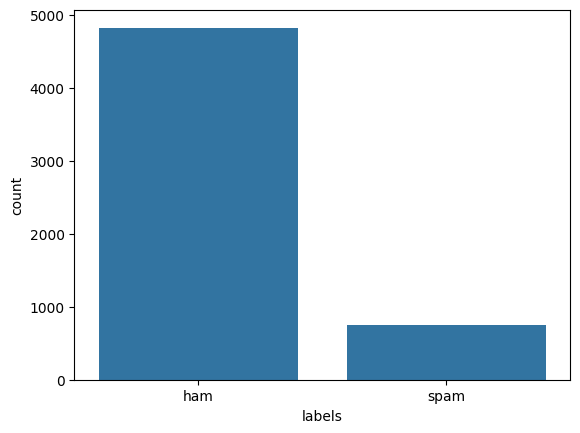

In [5]:
sns.countplot(x=df['labels'])


Data Text Processing

In [26]:
import nltk
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer


nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\acer\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\acer\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\acer\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
# Inisialisasi Lemmatizer
lemmatizer = WordNetLemmatizer()
# Dapatkan daftar stopwords bahasa Inggris
stop_words = set(stopwords.words('english'))
# Dapatkan daftar semua tanda baca
punctuation = set(string.punctuation)

def preprocess_text(text):
    # 1. Normalisasi (Lowercase)
    text = text.lower()
    
    # 2. Tokenisasi
    tokens = word_tokenize(text)
    
    # 3 & 4. Stopword/Punctuation Removal dan Lemmatization
    clean_tokens = []
    for token in tokens:
        # Hanya simpan token yang berupa alfabet (menghapus angka dan tanda baca)
        if token.isalpha():
            # Hanya simpan token yang BUKAN stopword
            if token not in stop_words:
                # 4. Lemmatization
                clean_token = lemmatizer.lemmatize(token)
                clean_tokens.append(clean_token)
    
    return ' '.join(clean_tokens)


contoh_teks = "Hello! This is a sample message, running 123 tests."
teks_bersih = preprocess_text(contoh_teks)
print(f"Teks Asli: {contoh_teks}")
print(f"Teks Bersih: {teks_bersih}")

Teks Asli: Hello! This is a sample message, running 123 tests.
Teks Bersih: hello sample message running test


In [28]:
# Inisialisasi Stemmer
stemmer = PorterStemmer()

def stem_text(text):
    text = text.lower()
    tokens = word_tokenize(text)
    
    stemmed_tokens = []
    for token in tokens:
        if token.isalpha() and token not in stop_words:
            stemmed_token = stemmer.stem(token)
            stemmed_tokens.append(stemmed_token)
            
    return ' '.join(stemmed_tokens)

# Contoh Stemming
contoh_teks_stem = "His studies and running activities are good."
teks_hasil_stem = stem_text(contoh_teks_stem)
print(f"\nContoh Stemming:")
print(f"Teks Asli: {contoh_teks_stem}")
print(f"Teks Hasil Stem: {teks_hasil_stem}")


Contoh Stemming:
Teks Asli: His studies and running activities are good.
Teks Hasil Stem: studi run activ good


7. Labeling data (Label Encoding)
Model machine learning tidak mengerti teks "ham" atau "spam". Kita perlu mengubahnya menjadi angka (misalnya: 0 untuk 'ham' dan 1 untuk 'spam').

In [17]:
# Mengubah label 'ham' menjadi 0 dan 'spam' menjadi 1
y = df['labels'].map({'ham': 0, 'spam': 1})

# Menyiapkan data fitur (teks SMS)
x = df['data']

print("Label setelah di-encode (0=ham, 1=spam):")
print(y.head())

Label setelah di-encode (0=ham, 1=spam):
0    0
1    0
2    1
3    0
4    0
Name: labels, dtype: int64


8. Text Vektorisasi (TF-IDF)

Menggunakan TF-IDF (Term Frequency-Inverse Document Frequency) untuk mengubah koleksi teks SMS menjadi matriks fitur numerik. TfidfVectorizer akan menghitung bobot setiap kata berdasarkan frekuensinya di satu dokumen dan kelangkaannya di semua dokumen.

In [18]:

tfidf = TfidfVectorizer(max_features=5000)

x_features = tfidf.fit_transform(x)

print(f"Bentuk matriks fitur (jumlah data, jumlah fitur/kata): {x_features.shape}")

Bentuk matriks fitur (jumlah data, jumlah fitur/kata): (5169, 5000)


9. Data splitting
Membagi dataset kita menjadi dua bagian: data latih (training data) untuk melatih model, dan data uji (testing data) untuk menguji seberapa baik performa model pada data yang belum pernah dilihat sebelumnya. Kita akan menggunakan skala 80% data latih dan 20% data uji.

In [19]:

xtrain, xtest, ytrain, ytest = train_test_split(
    x_features, 
    y, 
    test_size=0.2, 
    random_state=42
)

print(f"Ukuran data latih (xtrain): {xtrain.shape}")
print(f"Ukuran data uji (xtest): {xtest.shape}")
print(f"Ukuran label latih (ytrain): {ytrain.shape}")
print(f"Ukuran label uji (ytest): {ytest.shape}")

Ukuran data latih (xtrain): (4135, 5000)
Ukuran data uji (xtest): (1034, 5000)
Ukuran label latih (ytrain): (4135,)
Ukuran label uji (ytest): (1034,)


DATA MODELING

SVM

Support Vector Machine (SVM): SVM adalah model yang sangat efektif dalam ruang berdimensi tinggi, seperti klasifikasi teks. Model ini bekerja dengan mencari hyperplane (garis pemisah) terbaik yang dapat memisahkan dua kelas (dalam hal ini, 'ham' dan 'spam').

In [21]:
from sklearn.svm import SVC

svm_model = SVC(kernel='linear')
svm_model.fit(xtrain, ytrain) # train the model

y_pred_svm = svm_model.predict(xtest) # predict the labels for test set

# Evaluate the model
print("SVM Accuracy:", accuracy_score(ytest, y_pred_svm))
print("SVM Classification Report:\n", classification_report(ytest, y_pred_svm))
print("SVM Confusion Matrix:\n", confusion_matrix(ytest, y_pred_svm))

SVM Accuracy: 0.9825918762088974
SVM Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99       894
           1       0.98      0.89      0.93       140

    accuracy                           0.98      1034
   macro avg       0.98      0.94      0.96      1034
weighted avg       0.98      0.98      0.98      1034

SVM Confusion Matrix:
 [[891   3]
 [ 15 125]]


Random Forest Classifier

Random Forest Classifier: Ini adalah model ensemble yang terdiri dari banyak decision tree (pohon keputusan). Model ini menggabungkan hasil prediksi dari semua pohon untuk mendapatkan hasil akhir yang lebih akurat dan stabil.

In [22]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=100)
rf_model.fit(xtrain, ytrain)

y_pred_rf = rf_model.predict(xtest)
# 
print("Random Forest Accuracy:", accuracy_score(ytest, y_pred_rf))
print("Random Forest Classification Report:\n", classification_report(ytest, y_pred_rf))
print("Random Forest Confusion Matrix:\n", confusion_matrix(ytest, y_pred_rf))

Random Forest Accuracy: 0.9758220502901354
Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.99       894
           1       1.00      0.82      0.90       140

    accuracy                           0.98      1034
   macro avg       0.99      0.91      0.94      1034
weighted avg       0.98      0.98      0.97      1034

Random Forest Confusion Matrix:
 [[894   0]
 [ 25 115]]


Data Evaluasi
Setelah model dilatih,  perlu mengevaluasi seberapa baik kinerjanya menggunakan data uji.

1. Confusion Matrix
Confusion Matrix adalah tabel yang merangkum hasil prediksi. Ini menunjukkan:

True Positive (TP): Spam yang diprediksi benar sebagai Spam.

True Negative (TN): Ham yang diprediksi benar sebagai Ham.

False Positive (FP): Ham yang salah diprediksi sebagai Spam.

False Negative (FN): Spam yang salah diprediksi sebagai Ham.

2. Laporan Klasifikasi (Classification Report)
Laporan ini memberikan metrik yang lebih rinci:

Accuracy: Persentase prediksi yang benar secara keseluruhan.

Precision: Seberapa banyak yang diprediksi sebagai 'Spam' yang benar-benar 'Spam'. (Penting untuk menghindari False Positives).

Recall: Seberapa banyak 'Spam' yang sebenarnya berhasil dideteksi oleh model. (Penting untuk menghindari False Negatives).

F1-Score: Rata-rata harmonik dari Precision dan Recall.

SVM Accuracy: 0.9826

SVM Confusion Matrix:
[[891   3]
 [ 15 125]]

SVM Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       894
           1       0.98      0.89      0.93       140

    accuracy                           0.98      1034
   macro avg       0.98      0.94      0.96      1034
weighted avg       0.98      0.98      0.98      1034



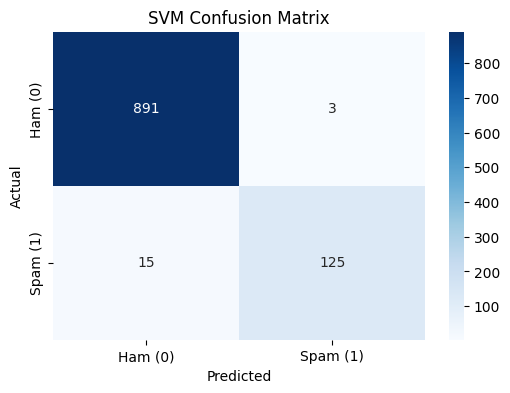

In [ ]:
acc_svm = accuracy_score(ytest, y_pred_svm)

print(f"SVM Accuracy: {acc_svm:.4f}")
print("\nSVM Confusion Matrix:")
print(confusion_matrix(ytest, y_pred_svm))
print("\nSVM Classification Report:")
print(classification_report(ytest, y_pred_svm))

# Visualisasi Confusion Matrix SVM
plt.figure(figsize=(6, 4))
cm_svm = confusion_matrix(ytest, y_pred_svm)
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Ham (0)', 'Spam (1)'], 
            yticklabels=['Ham (0)', 'Spam (1)'])
plt.title('SVM Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Random Forest Accuracy: 0.9758

Random Forest Confusion Matrix:
[[894   0]
 [ 25 115]]

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       894
           1       1.00      0.82      0.90       140

    accuracy                           0.98      1034
   macro avg       0.99      0.91      0.94      1034
weighted avg       0.98      0.98      0.97      1034



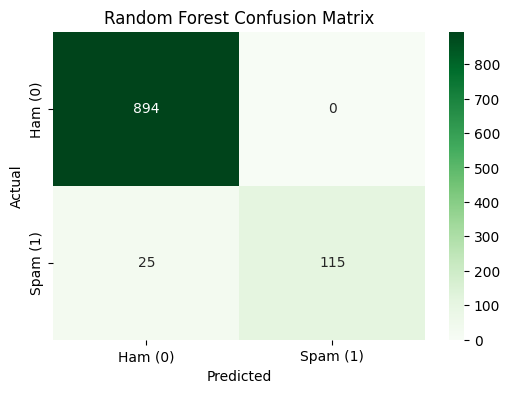

In [ ]:
acc_rf = accuracy_score(ytest, y_pred_rf)

print(f"Random Forest Accuracy: {acc_rf:.4f}")
print("\nRandom Forest Confusion Matrix:")
print(confusion_matrix(ytest, y_pred_rf))
print("\nRandom Forest Classification Report:")
print(classification_report(ytest, y_pred_rf))

# Visualisasi Confusion Matrix Random Forest
plt.figure(figsize=(6, 4))
cm_rf = confusion_matrix(ytest, y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens', 
            xticklabels=['Ham (0)', 'Spam (1)'], 
            yticklabels=['Ham (0)', 'Spam (1)'])
plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Perbandingan Model

Membandingkan performa (akurasi) dari kedua model yang telah kita bangun menggunakan diagram batang (bar chart) sederhana.

C:\Users\acer\AppData\Local\Temp\ipykernel_1596\749356789.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Accuracy', data=comparison_df, palette='viridis')


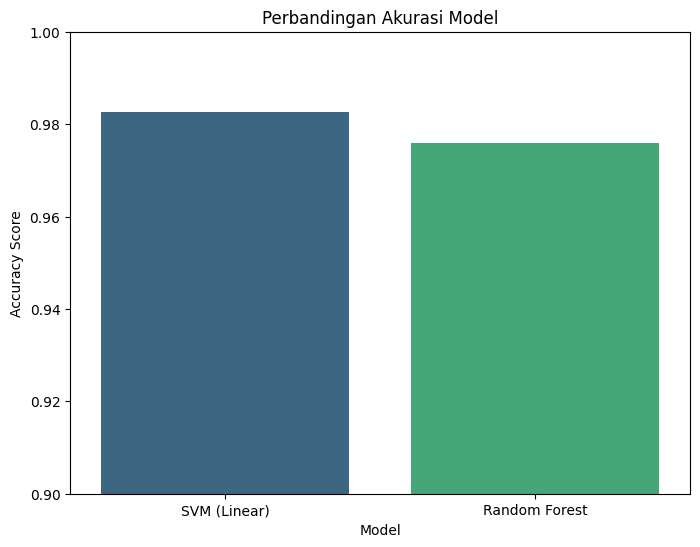

           Model  Accuracy
0   SVM (Linear)  0.982592
1  Random Forest  0.975822


In [25]:
# Membuat DataFrame untuk perbandingan
comparison_data = {
    'Model': ['SVM (Linear)', 'Random Forest'],
    'Accuracy': [acc_svm, acc_rf]
}
comparison_df = pd.DataFrame(comparison_data)

# Membuat bar chart
plt.figure(figsize=(8, 6))
sns.barplot(x='Model', y='Accuracy', data=comparison_df, palette='viridis')
plt.title('Perbandingan Akurasi Model')
plt.ylabel('Accuracy Score')
plt.ylim(0.9, 1.0) # Mengatur limit y agar perbedaan terlihat jelas
plt.show()

print(comparison_df)